In [1]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Visualization of Audio signal in time series domain

train_audio_path='C:\\Users/user/Desktop/ML/Data/SpeechtoText/train/audio/'
samples, sample_rate=librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr=16000)

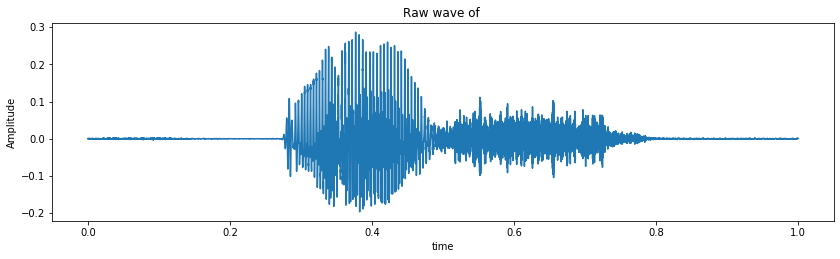

In [3]:
fig=plt.figure(figsize=(14,8))
ax1=fig.add_subplot(211)
ax1.set_title('Raw wave of'+' ')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [4]:
# sampling rate
ipd.Audio(samples, rate=sample_rate)
print(sample_rate)

16000


In [6]:
#Resampling 16000Hz to 8000Hz (most of speech-related frequencies are present at 8000Hz)
samples=librosa.resample(samples, sample_rate,8000)
ipd.Audio(samples, rate=8000)

In [9]:
# understand the number of voice recordings for each voice command
labels=os.listdir(train_audio_path)
no_of_recordings=[]
for label in labels:
    waves=[f for f in os.listdir(train_audio_path+'/'+label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))

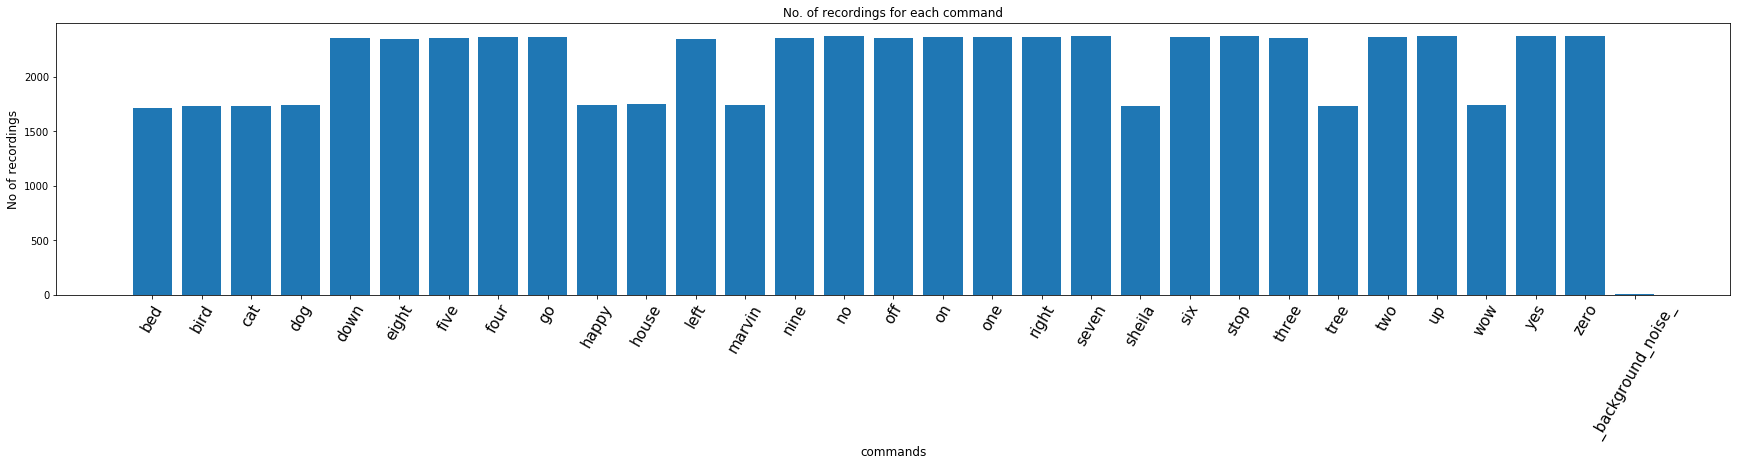

In [11]:
#plot
plt.figure(figsize=(30,5))
index=np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show

labels=["yes", "no","up","down","left","right","on","off","stop","go"]

In [13]:
labels=["yes","no","up","down","left","right","on","off","stop","go"]

(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <a list of 10 Patch objects>)

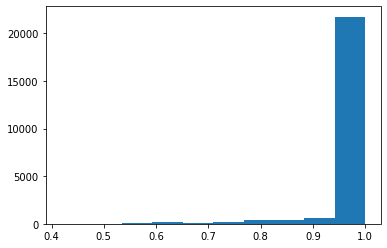

In [16]:
duration_of_recordings=[]
for label in labels:
    waves= [f for f in os.listdir(train_audio_path +'/'+label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples= wavfile.read(train_audio_path+'/'+label+'/'+wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
        
plt.hist(np.array(duration_of_recordings))        

### Preprocessing the audio waves

- resampling
- removing shorter commands of less than 1 second

In [23]:
train_audio_path='C:\\Users/user/Desktop/ML/Data/SpeechtoText/train/audio/'

all_wave=[]
all_label=[]
for label in labels:
    print(label)
    #waves=[f for f in os.listdir(train_audio_path)+ '/'+ label) if f.endswith('.wav')]
    waves= [f for f in os.listdir(train_audio_path +'/'+label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate=librosa.load(train_audio_path+ '/'+ label+ '/' + wav, sr=160000)
        samples=librosa.resample(samples, sample_rate,8000)
        if(len(samples)==8000):
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


In [24]:
#output labels convert into integer encoded
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y=le.fit_transform(all_label)
classes=list(le.classes_)

In [26]:
# convert the integer encoded labels to one hot vector (since multi-classification problem)
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

Using TensorFlow backend.


In [27]:
# reshape 2D array to 3D array(for input to conv1d must be a 3D array)
all_wave=np.array(all_wave).reshape(-1,8000,1)

In [28]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val =train_test_split(np.array(all_wave), np.array(y), stratify=y, test_size=0.2, random_state=777, shuffle=True)

### Model Building

for the speech-to-text model usingcov1d.

In [29]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

In [32]:
inputs=Input(shape=(8000,1))

#1st conv1d layer
conv=Conv1D(8,13,padding='valid', activation='relu', strides=1)(inputs)
conv=MaxPooling1D(3)(conv)
conv=Dropout(0.3)(conv)

#2nd conv1D layer
conv=Conv1D(16,11,padding='valid', activation='relu', strides=1)(inputs)
conv=MaxPooling1D(3)(conv)
conv=Dropout(0.3)(conv)

inputs=Input(shape=(8000,1))

#1st conv1d layer
conv=Conv1D(8,13,padding='valid', activation='relu', strides=1)(inputs)
conv=MaxPooling1D(3)(conv)
conv=Dropout(0.3)(conv)

#2nd conv1D layer
conv=Conv1D(16,11,padding='valid', activation='relu', strides=1)(inputs)
conv=MaxPooling1D(3)(conv)
conv=Dropout(0.3)(conv)

#3rd conv1d layer
conv=Conv1D(32,9,padding='valid', activation='relu', strides=1)(inputs)
conv=MaxPooling1D(3)(conv)
conv=Dropout(0.3)(conv)

#4th conv1D layer
conv=Conv1D(64,7,padding='valid', activation='relu', strides=1)(inputs)
conv=MaxPooling1D(3)(conv)
conv=Dropout(0.3)(conv)

# flatten layer
conv=Flatten()(conv)

#Dense layer1
conv=Dense(256, activation='relu')(conv)
conv=Dropout(0.3)(conv)

#Dense layer2
conv=Dense(128, activation='relu')(conv)
conv=Dropout(0.3)(conv)

outputs=Dense(len(labels), activation='softmax')(conv)

model=Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 7994, 64)          512       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 2664, 64)          0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 2664, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 170496)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               43647232  
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0   

In [33]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [50]:
es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)
mc=ModelCheckpoint('C:\\Users/user/Desktop/ML/Data/SpeechtoText/train/audio/best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [51]:
history=model.fit(x_tr, y_tr, epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val, y_val))

Train on 17049 samples, validate on 4263 samples
Epoch 1/100
17049/17049 [==============================] - 656s 38ms/step - loss: 0.4015 - accuracy: 0.8711 - val_loss: 1.8801 - val_accuracy: 0.5749
Epoch 2/100
17049/17049 [==============================] - 616s 36ms/step - loss: 0.4097 - accuracy: 0.8753 - val_loss: 1.8459 - val_accuracy: 0.5817
Epoch 3/100
17049/17049 [==============================] - 617s 36ms/step - loss: 0.3770 - accuracy: 0.8840 - val_loss: 1.8406 - val_accuracy: 0.5871
Epoch 4/100
17049/17049 [==============================] - 618s 36ms/step - loss: 0.3562 - accuracy: 0.8906 - val_loss: 2.0097 - val_accuracy: 0.5735
Epoch 5/100
17049/17049 [==============================] - 619s 36ms/step - loss: 0.3341 - accuracy: 0.8950 - val_loss: 1.9578 - val_accuracy: 0.5778
Epoch 6/100
17049/17049 [==============================] - 616s 36ms/step - loss: 0.3121 - accuracy: 0.9027 - val_loss: 2.0580 - val_accuracy: 0.5670
Epoch 7/100
17049/17049 [==========================

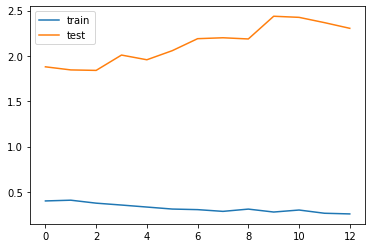

In [52]:
#Diagnostic plot
from matplotlib import pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [55]:
# Loading the best model
from keras.models import load_model
model=load_model('C:/Users/user/Desktop/ML/Data/SpeechtoText/train/audio/best_model.hdf5')
model.summary()

OSError: Unable to open file (unable to open file: name = 'C:/Users/user/Desktop/ML/Data/SpeechtoText/train/audio/best_model.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [41]:
#print(os.getcwd())

C:\Users\user


In [56]:
# function that predicts text for the given audio
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [57]:
# prediction on validation data
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:", classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: down


In [58]:
print("Text:", predict(samples))

Text: down


In [62]:
# record voice commands
import sounddevice as sd
import soundfile as sf
samplerate=16000
duration=1 #seconds
filename='yes.wav'
print("start")
mydata=sd.rec(int(samplerate*duration), samplerate=samplerate, channels=1, blocking=True)
print("end")    
sd.wait()
sf.write(filename, mydata,samplerate)

start
end


In [ ]:
#read the saved voice command and convert it to text
os.listdir('C:\\Users/user/Desktop/ML/Data/SpeechtoText/train/audio/Ryan.wav')

In [73]:
filepath='C:\\Users/user/Desktop/ML/Data/SpeechtoText/train/audio'

In [77]:
!pip install pydub

In [78]:
!pip install ffmpeg

  Created wheel for ffmpeg: filename=ffmpeg-1.4-cp37-none-any.whl size=6088 sha256=d10a7c88e5b63dfc2d9b65a45b6529551317943ba3a504aa582fe88152a5213b
  Stored in directory: C:\Users\user\AppData\Local\pip\Cache\wheels\b6\68\c3\a05a35f647ba871e5572b9bbfc0b95fd1c6637a2219f959e7a
Successfully built ffmpeg


In [81]:
!pip install ffmpy

  Created wheel for ffmpy: filename=ffmpy-0.3.0-cp37-none-any.whl size=4717 sha256=f5e09068de4091eb8bc1cffd258e64f810104a551afb46bfa592e74185854bef
  Stored in directory: C:\Users\user\AppData\Local\pip\Cache\wheels\cc\ac\c4\bef572cb7e52bfca170046f567e64858632daf77e0f34e5a74
Successfully built ffmpy


In [130]:
import os
import argparse
from pydub import AudioSegment

formats_to_convert=['.mp4']

for (dirpath, dirnames, filenames) in os.walk("CommandVoice/"):
    for filename in filenames:
        if filename.endswith(tuple(formats_t_convert)):
            
            filepath=dirpath+'/'+filename
            (path, file_extension)=file_extension.replace('.', '')
            try:
                track= AudioSegment.from_file(filepath, file_extension_final)
                wav_filename= filename.replace(file_extension_final, 'wav')
                wav_path=dirpath+'/'+wav_filename
                print('CONVERTING: '+ str(filepath))
                file_handle= track.export(wav_path, format='wav')
                os.remove(filepath)
            except:
                print("ERROR CONVERTING "+ str(filepath))
                
                
dirpath='C:\\Users/user/Desktop/ML/Data/SpeechtoText/train/audio/CommandVoice'
filename='Ryan'
#!mv CommandVoice wav_files                

In [ ]:
from pydub import AudioSegment
sound = AudioSegment.from_mp3("C:\\Users/user/Desktop/ML/Data/SpeechtoText/train/audio/CommandVoice/Ryan.mp3")
sound.export("C:\\Users/user/Desktop/ML/Data/SpeechtoText/train/audio/Ryan.wav", format="wav")

In [110]:
import os
import ffmpy

inputdir='C:\\Users/user/Desktop/ML/Data/SpeechtoText/train/audio/CommandVoice'
for filename in os.listdir(inputdir):
    actual_filename=filename[:-4] # >>.mp4
    if (filename.endswith(".mp4")):
        output=os.system("ffmpeg -i {} -acodec pcm_s161e -ar 16000 out.wav".format(filename, actual_filename))
    else:
        continue

In [111]:
print(filename)

Ryan.mp4


In [116]:
print(actual_filename)

Ryan


In [119]:
print(os.system("ffmpeg -i {} -acodec pcm_s161e -ar 16000 out.wav".format(filename, actual_filename)))

1


In [ ]:
#reading the voice commands
filepath='C:\\Users/user/Desktop/ML/Data/SpeechtoText/train/audio/CommandVoice'
samples, sample_rate=librosa.load(filepath+'/'+actual_filename, sr=16000)
samples=librosa.resample(samples, sample_rate,8000)
ipd.Audio(samples, rate=8000)

In [136]:
#reading the voice commands

filepath='C:\\Users/user/Desktop/ML/Data/SpeechtoText/train/audio'
samples, sample_rate=librosa.load(filepath+'/'+'sheila.wav', sr=16000)
samples=librosa.resample(samples, sample_rate,8000)
ipd.Audio(samples, rate=8000)

In [134]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [135]:
predict(samples)

'down'